In [4]:
import os
os.chdir('/Users/yinancheng/Documents/Project/TrustworthyAI/Advertisement/')

import pandas as pd

path = 'Data/nonpotential_cillabel'
result_path = 'Result/nonpotential_cillabel'
df_train = pd.read_csv(f'{path}/df_train.csv')
df_syn_ctgan = pd.read_csv(f'{path}/df_syn_ctgan.csv')
df_syn_ctabgan = pd.read_csv(f'{path}/df_syn_ctabgan.csv')
df_syn_tvae = pd.read_csv(f'{path}/df_syn_tvae.csv')
df_syn_ds = pd.read_csv(f'{path}/df_syn_ds.csv')
#df_syn_great = pd.read_csv(f'{path}/df_syn_great.csv')
df_syn_tabula = pd.read_csv(f'{path}/df_syn_tabula.csv')
df_syn_tabddpm = pd.read_csv(f'{path}/df_syn_tabddpm.csv')
df_holdout = pd.read_csv(f'{path}/df_holdout.csv')
df_val = pd.read_csv(f'{path}/df_val.csv')
print("data is loaded...")

data is loaded...


In [5]:
df_syn_tabula.loc[df_syn_tabula['cillabel'] > 1, 'cillabel'] = 1
df_syn_tabula.to_csv(f"{path}/df_syn_tabula.csv", index = True)

df_syn_tabula = df_syn_tabula[df_train.columns]

In [6]:
from Dataset_Utility import utility_functions as uf
uf.calculate_label_rate2(df_train, 'cillabel')
uf.calculate_label_rate2(df_syn_ctgan, 'cillabel')
uf.calculate_label_rate2(df_syn_ctabgan, 'cillabel')
uf.calculate_label_rate2(df_syn_tvae, 'cillabel')
uf.calculate_label_rate2(df_syn_ds, 'cillabel')
uf.calculate_label_rate2(df_syn_tabula, 'cillabel')
uf.calculate_label_rate2(df_syn_tabddpm, 'cillabel')
uf.calculate_label_rate2(df_holdout, 'cillabel')
uf.calculate_label_rate2(df_val, 'cillabel')

Total Sample size is 19999, Positive Sample size is 4, Negative Sample size is 19995, label rate is 0.00020005001250312577
Total Sample size is 19999, Positive Sample size is 201, Negative Sample size is 19798, label rate is 0.010152540660672796
Total Sample size is 19999, Positive Sample size is 290, Negative Sample size is 19709, label rate is 0.014714090009640265
Total Sample size is 19999, Positive Sample size is 4, Negative Sample size is 19995, label rate is 0.00020005001250312577
Total Sample size is 19999, Positive Sample size is 12, Negative Sample size is 19987, label rate is 0.0006003902536648822
Total Sample size is 19999, Positive Sample size is 2, Negative Sample size is 19997, label rate is 0.00010001500225033755
Total Sample size is 19999, Positive Sample size is 1766, Negative Sample size is 18233, label rate is 0.09685734656940712
Total Sample size is 19999, Positive Sample size is 4, Negative Sample size is 19995, label rate is 0.00020005001250312577
Total Sample siz

In [7]:
# Dictionary of samples
samples = {
    'Training': df_train,
    'Holdout': df_holdout,
    'CTGAN': df_syn_ctgan,
    'CTABGAN': df_syn_ctabgan,
    'TVAE': df_syn_tvae,
    'DS': df_syn_ds,
    #'GReaT': df_syn_great,
    'Tabula': df_syn_tabula,
    'TabDDPM': df_syn_tabddpm
}

In [8]:
for name, sample in samples.items():
    globals()[f'X_{name}'] = sample.drop('cillabel', axis=1) # Predictors
    globals()[f'y_{name}'] = sample['cillabel'] # Response

X_val = df_val.drop('cillabel', axis=1) # Predictors of valide
y_val = df_val['cillabel'] # Response of valid

In [9]:
features = [f"F{i}" for i in range(X_Training.shape[1])]

In [10]:
pd.DataFrame({'Feature':features, 'Name':X_Training.columns})

,Feature,Name
0,F0,u_phonePrice
1,F1,u_browserLifeCycle
2,F2,u_browserMode
3,F3,u_feedLifeCycle
4,F4,u_refreshTimes
5,F5,i_regionEntity
6,F6,i_cat
7,F7,i_dislikeTimes
8,F8,i_upTimes
9,F9,i_dtype


# Feature Importance

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler 
from sklearn.inspection import permutation_importance
import shap

for sample in samples.keys():
    X_train = globals()[f'X_{sample}']
    y_train = globals()[f'y_{sample}']
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_val)
       
    #Random Forest
    RF = RandomForestClassifier(random_state=0)
    RF.fit(X_train, y_train)
    rf_imp = RF.feature_importances_
    globals()[f'rf_imp_{sample}'] = rf_imp
    
    per_imp = permutation_importance(RF, X_test, y_val, n_repeats=30, random_state=0)
    globals()[f'per_imp_{sample}_rf'] = per_imp
    
    explainer = shap.Explainer(RF)
    shap_values = explainer(X_test)[:,:,1]
    globals()[f'shap_imp_{sample}_rf'] = shap_values
    
    #XGBoost
    XGB = XGBClassifier()
    XGB.fit(X_train, y_train)
    xgb_imp = XGB.feature_importances_
    globals()[f'xgb_imp_{sample}'] = xgb_imp
    
    per_imp = permutation_importance(XGB, X_test, y_val, n_repeats=30, random_state=0)
    globals()[f'per_imp_{sample}_xgb'] = per_imp
    
    explainer = shap.Explainer(XGB)
    shap_values = explainer(X_test)
    globals()[f'shap_imp_{sample}_xgb'] = shap_values
    

## Random Forest Feature Importance

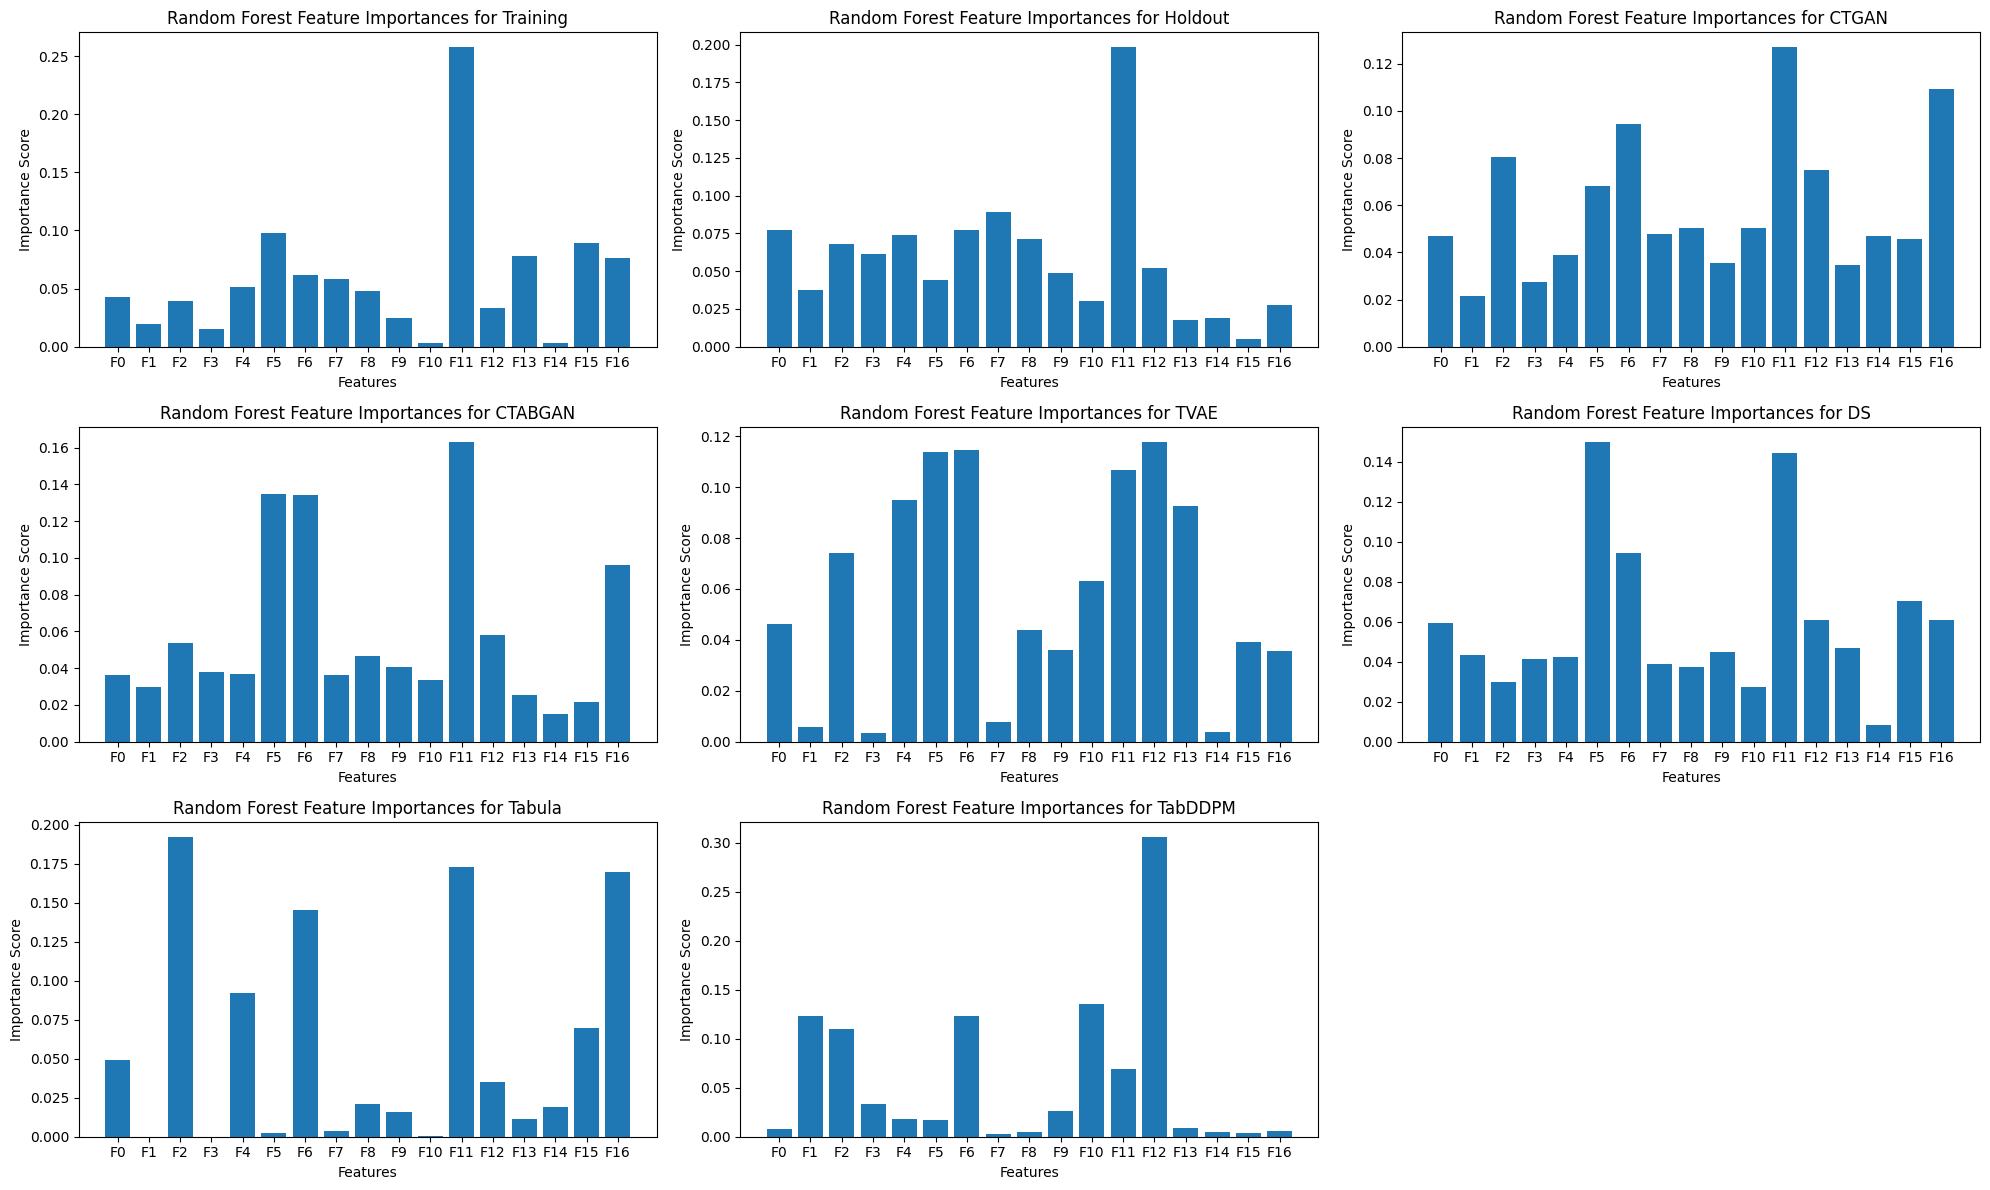

In [13]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(3, 3, figsize=(20, 12))
ax = ax.flatten()
for i, sample in enumerate(samples.keys()):
    importances = globals()[f'rf_imp_{sample}']
    ax[i].bar(features, importances)
    ax[i].set_title(f"Random Forest Feature Importances for {sample}")
    ax[i].set_xlabel("Features")
    ax[i].set_ylabel("Importance Score")
    
for j in range(len(samples.keys()), len(ax)):
    fig.delaxes(ax[j])
        
plt.tight_layout()
plt.show()
plt.close()

## XGBoost Feature Importance

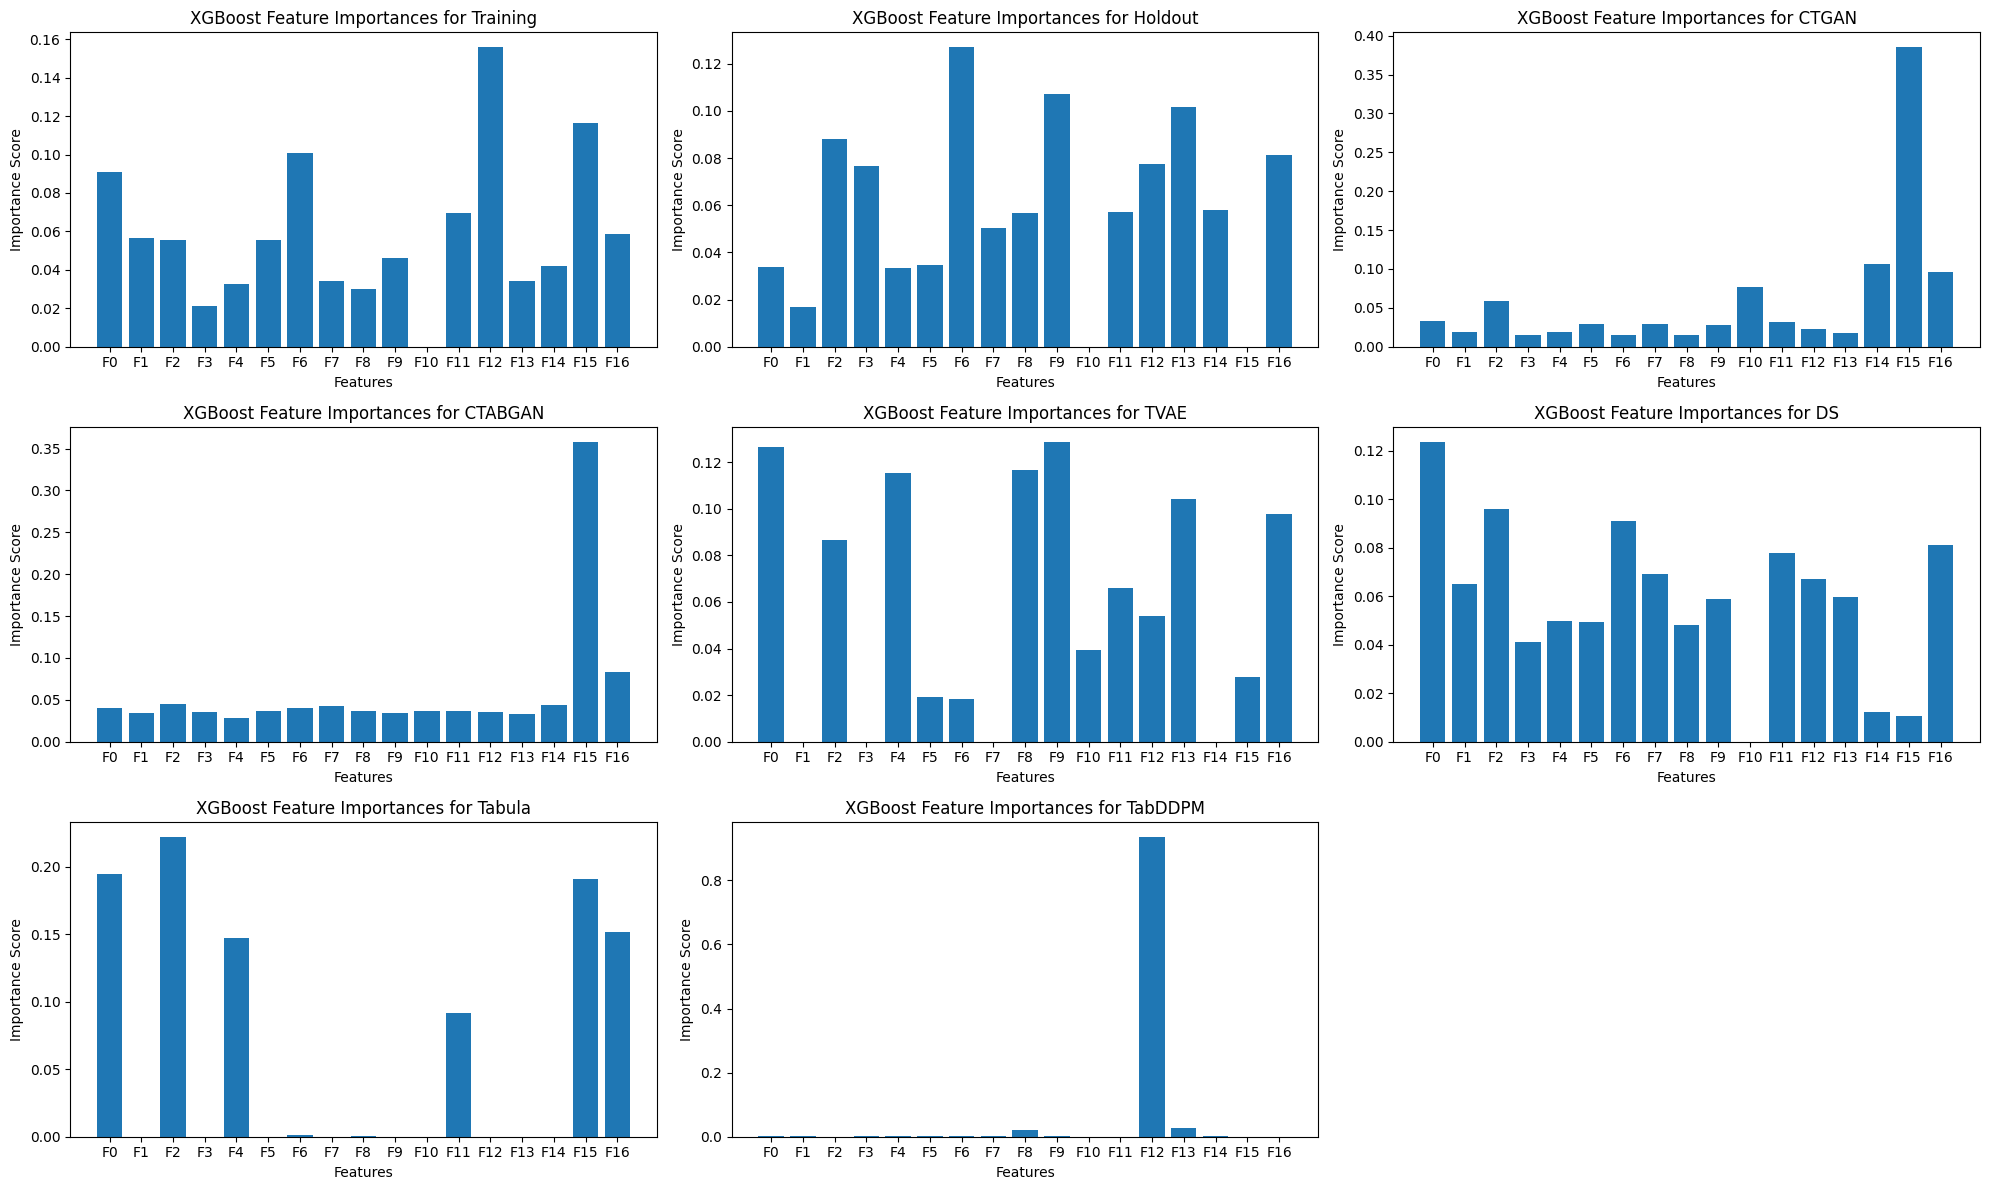

In [14]:
fig, ax = plt.subplots(3, 3, figsize=(20, 12))
ax = ax.flatten()
for i, sample in enumerate(samples.keys()):
    importances = globals()[f'xgb_imp_{sample}']
    ax[i].bar(features, importances)
    ax[i].set_title(f"XGBoost Feature Importances for {sample}")
    ax[i].set_xlabel("Features")
    ax[i].set_ylabel("Importance Score")
    
for j in range(len(samples.keys()), len(ax)):
    fig.delaxes(ax[j])
        
plt.tight_layout()
plt.show()
plt.close()

## Permutation Feature Importance 

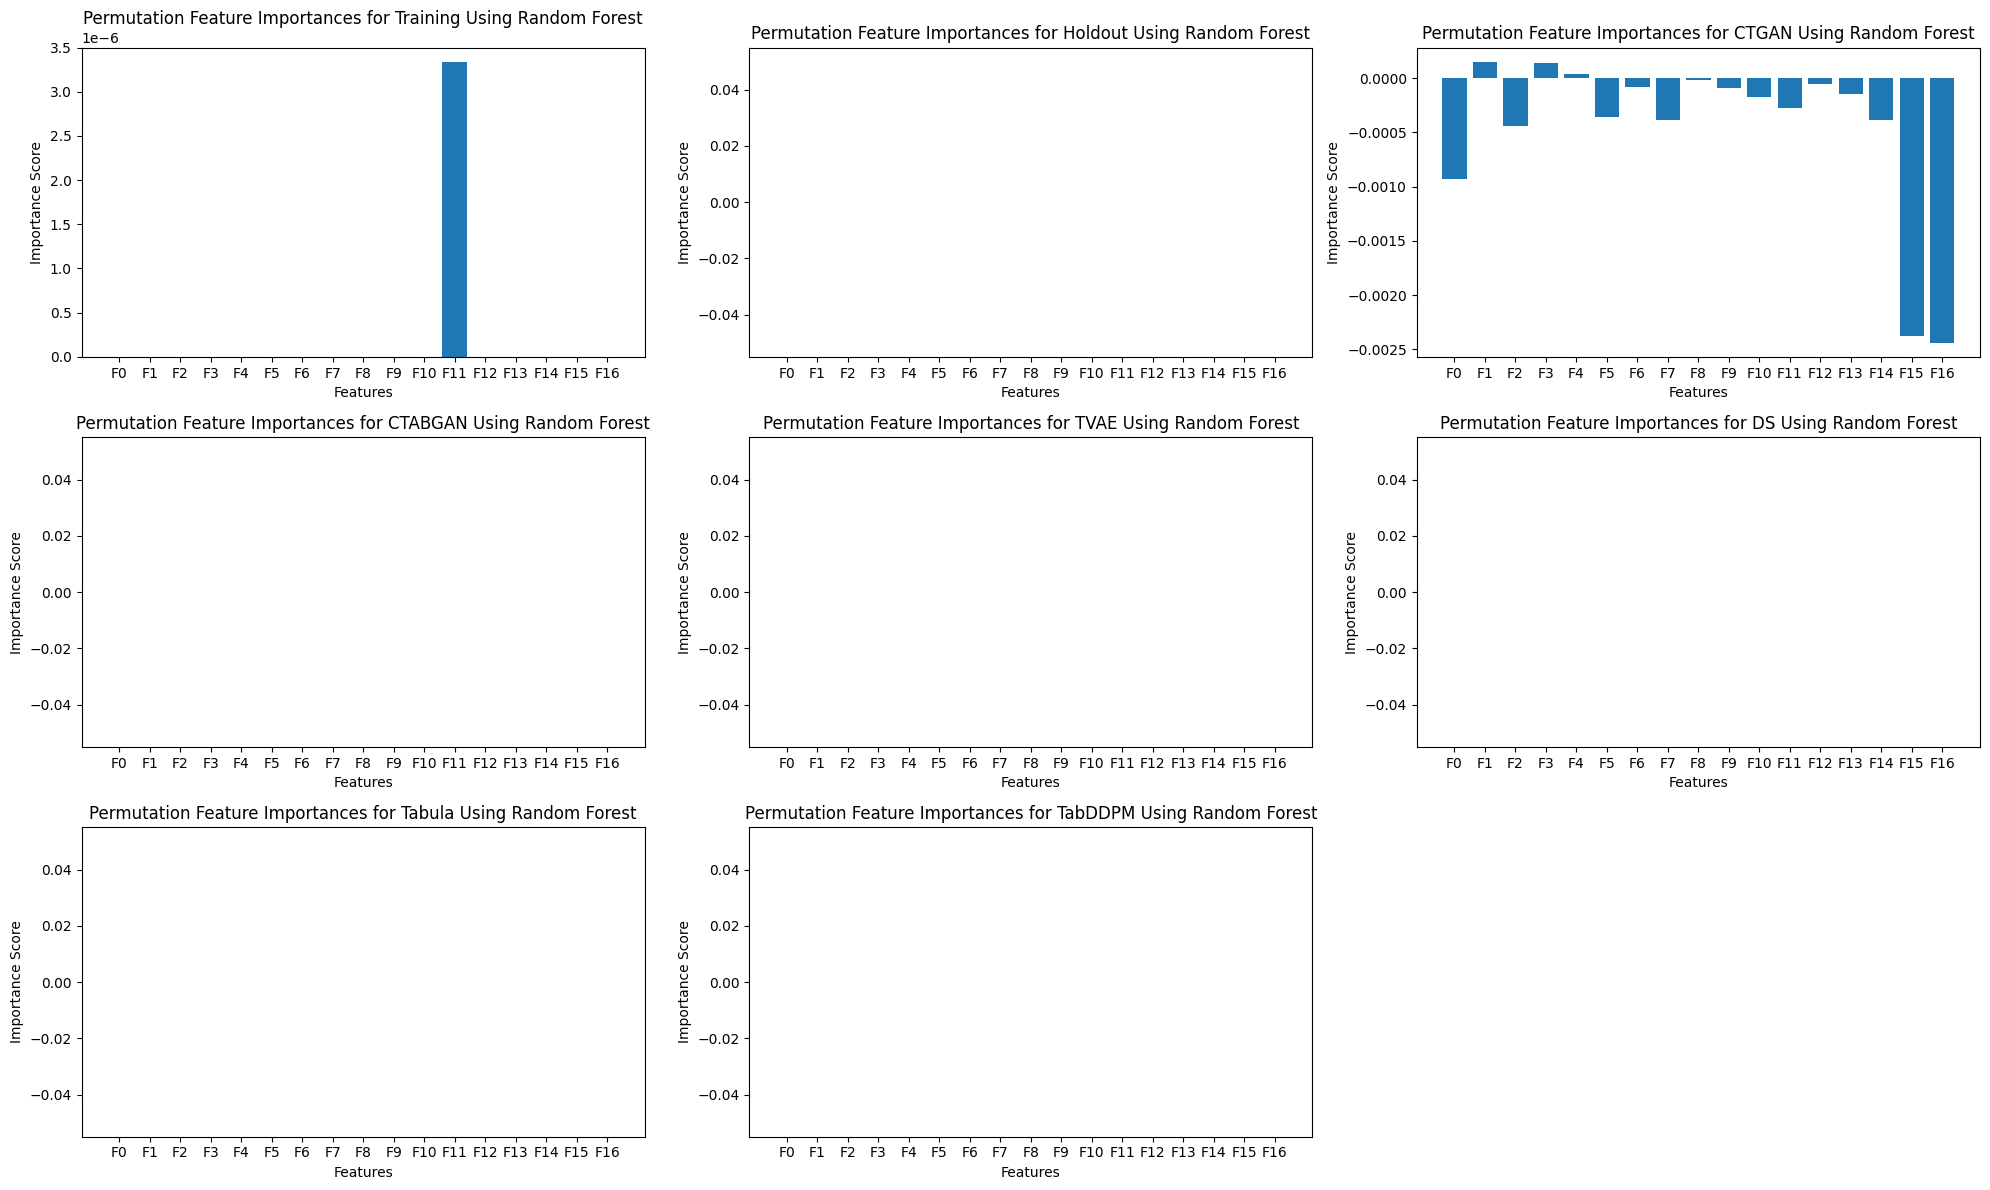

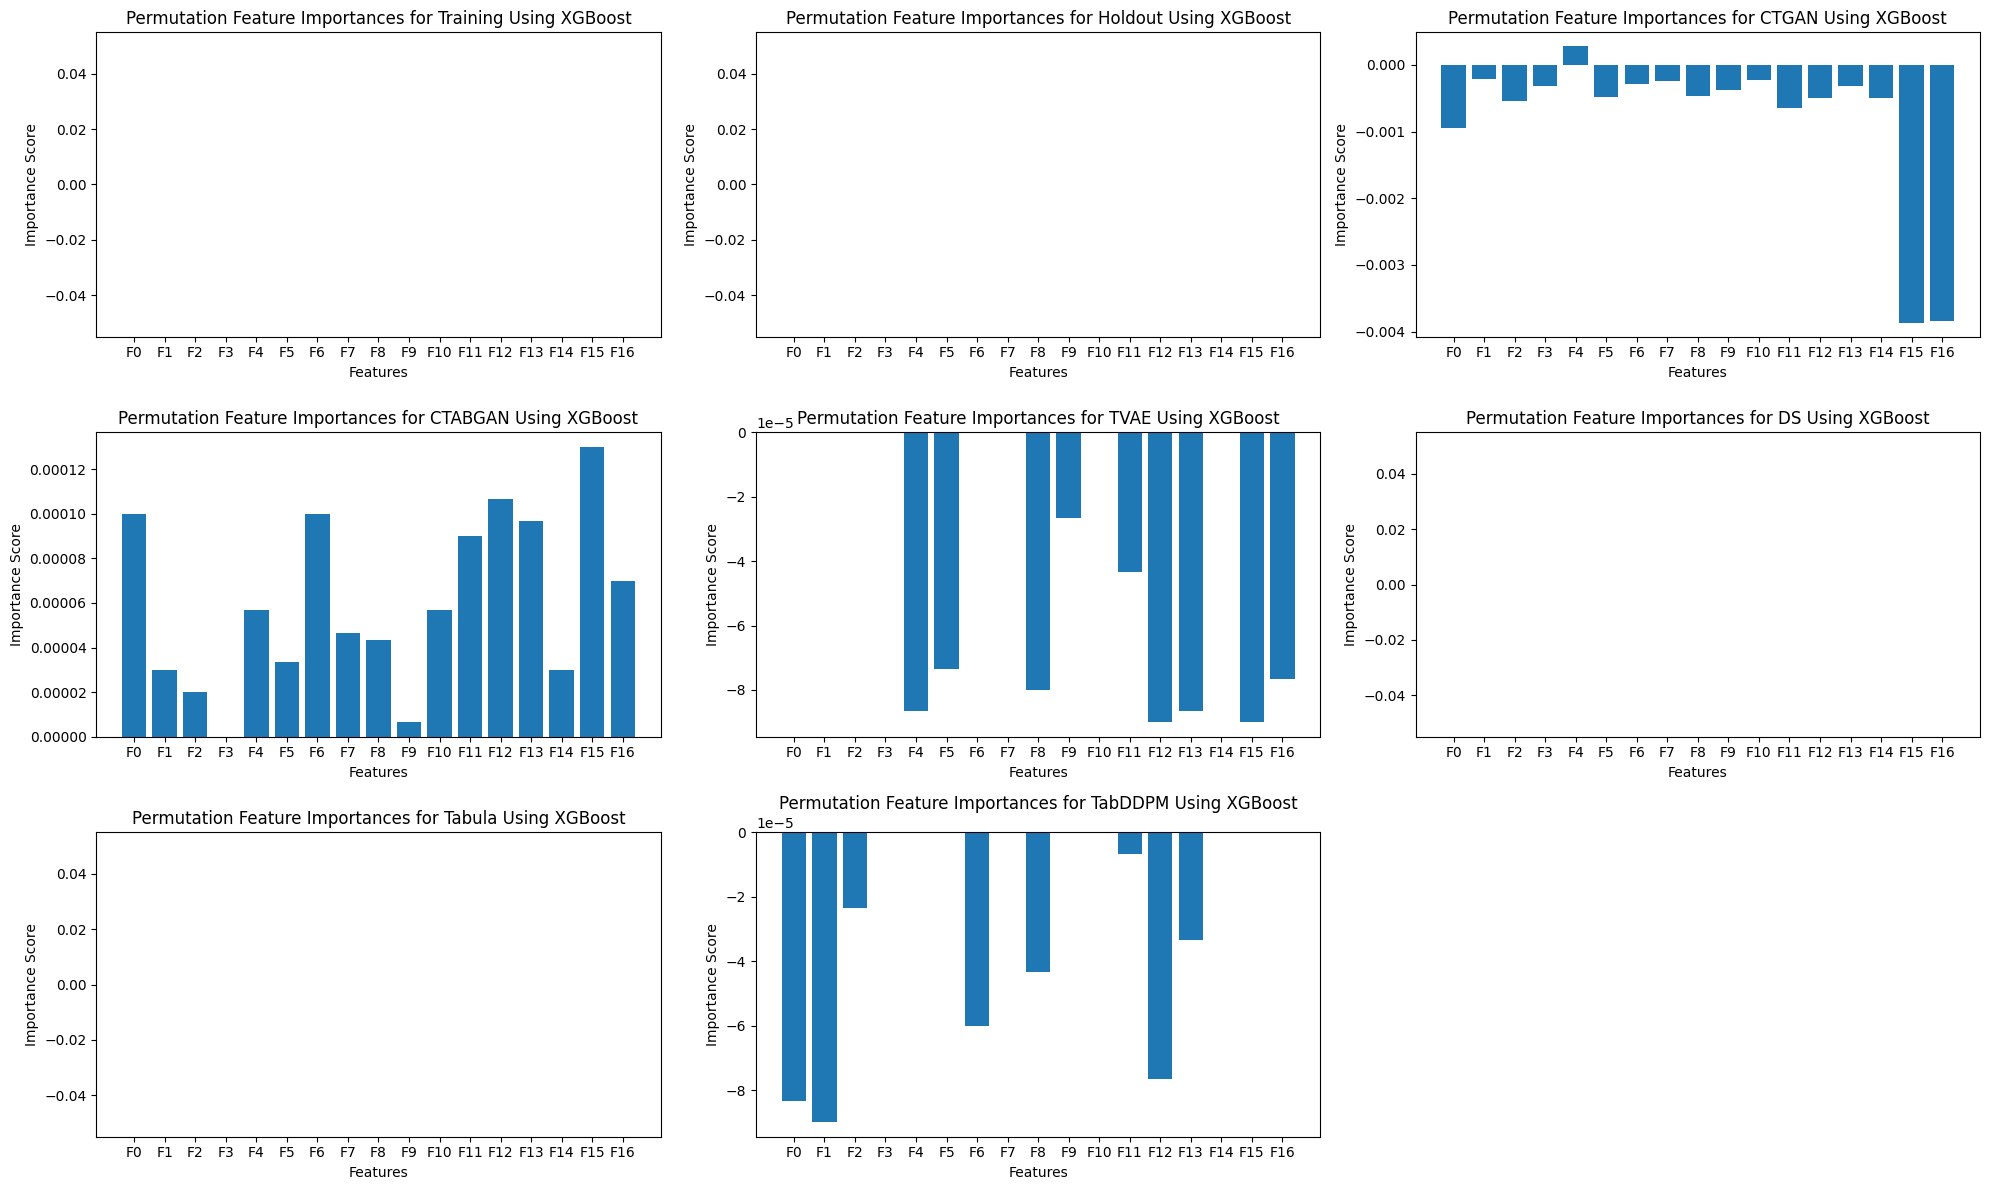

In [15]:
from sklearn.inspection import permutation_importance

fig, ax = plt.subplots(3, 3, figsize=(20, 12))
ax = ax.flatten()
for i, sample in enumerate(samples.keys()):
    importances = globals()[f'per_imp_{sample}_rf']
    ax[i].bar(features, importances.importances_mean)
    ax[i].set_title(f"Permutation Feature Importances for {sample} Using Random Forest")
    ax[i].set_xlabel("Features")
    ax[i].set_ylabel("Importance Score")
    
for j in range(len(samples.keys()), len(ax)):
    fig.delaxes(ax[j])
        
plt.tight_layout()
plt.show()
plt.close()


fig, ax = plt.subplots(3, 3, figsize=(20, 12))
ax = ax.flatten()
for i, sample in enumerate(samples.keys()):
    importances = globals()[f'per_imp_{sample}_xgb']
    ax[i].bar(features, importances.importances_mean)
    ax[i].set_title(f"Permutation Feature Importances for {sample} Using XGBoost")
    ax[i].set_xlabel("Features")
    ax[i].set_ylabel("Importance Score")
    
for j in range(len(samples.keys()), len(ax)):
    fig.delaxes(ax[j])
        
plt.tight_layout()
plt.show()
plt.close()

## SHAP Value

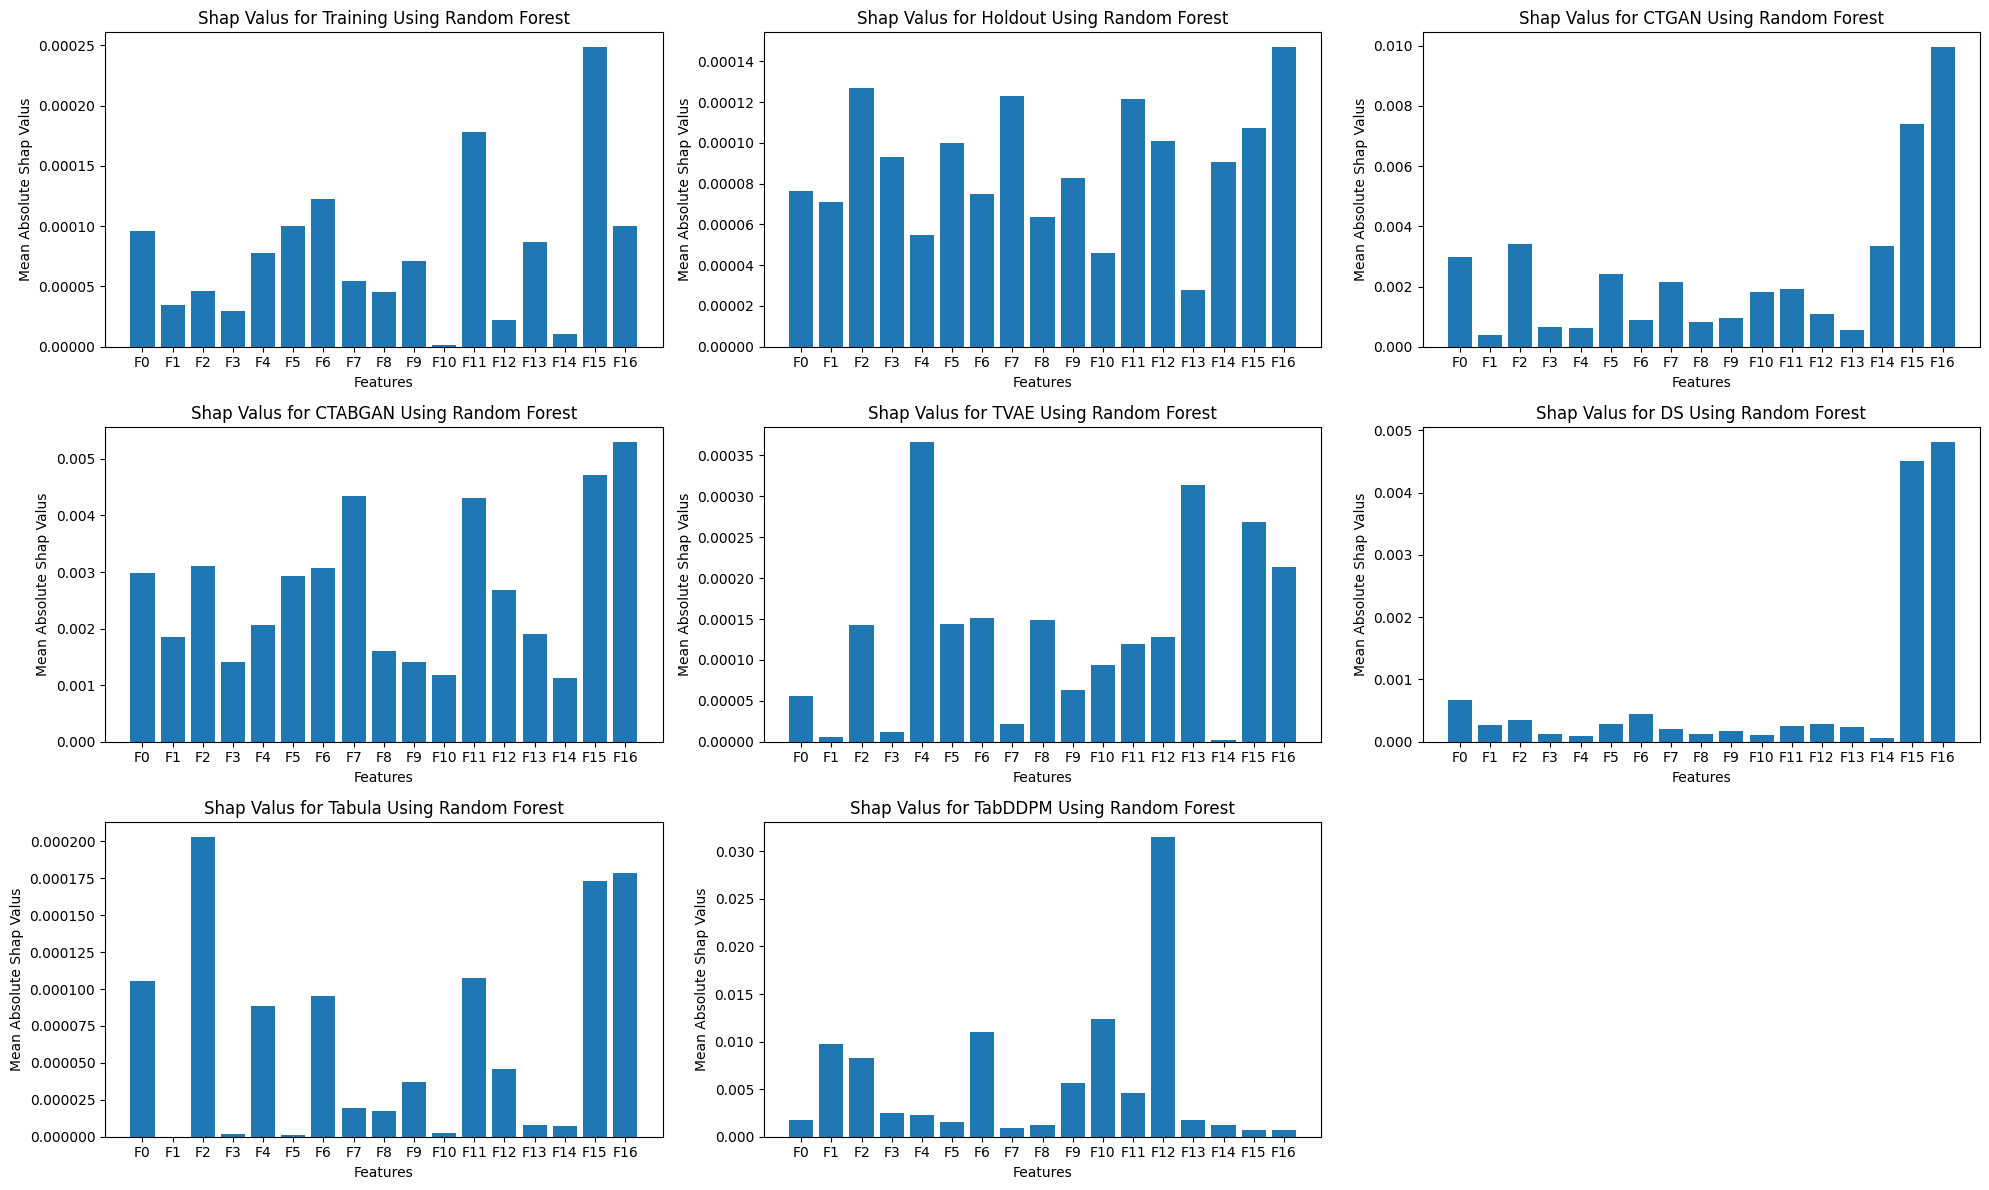

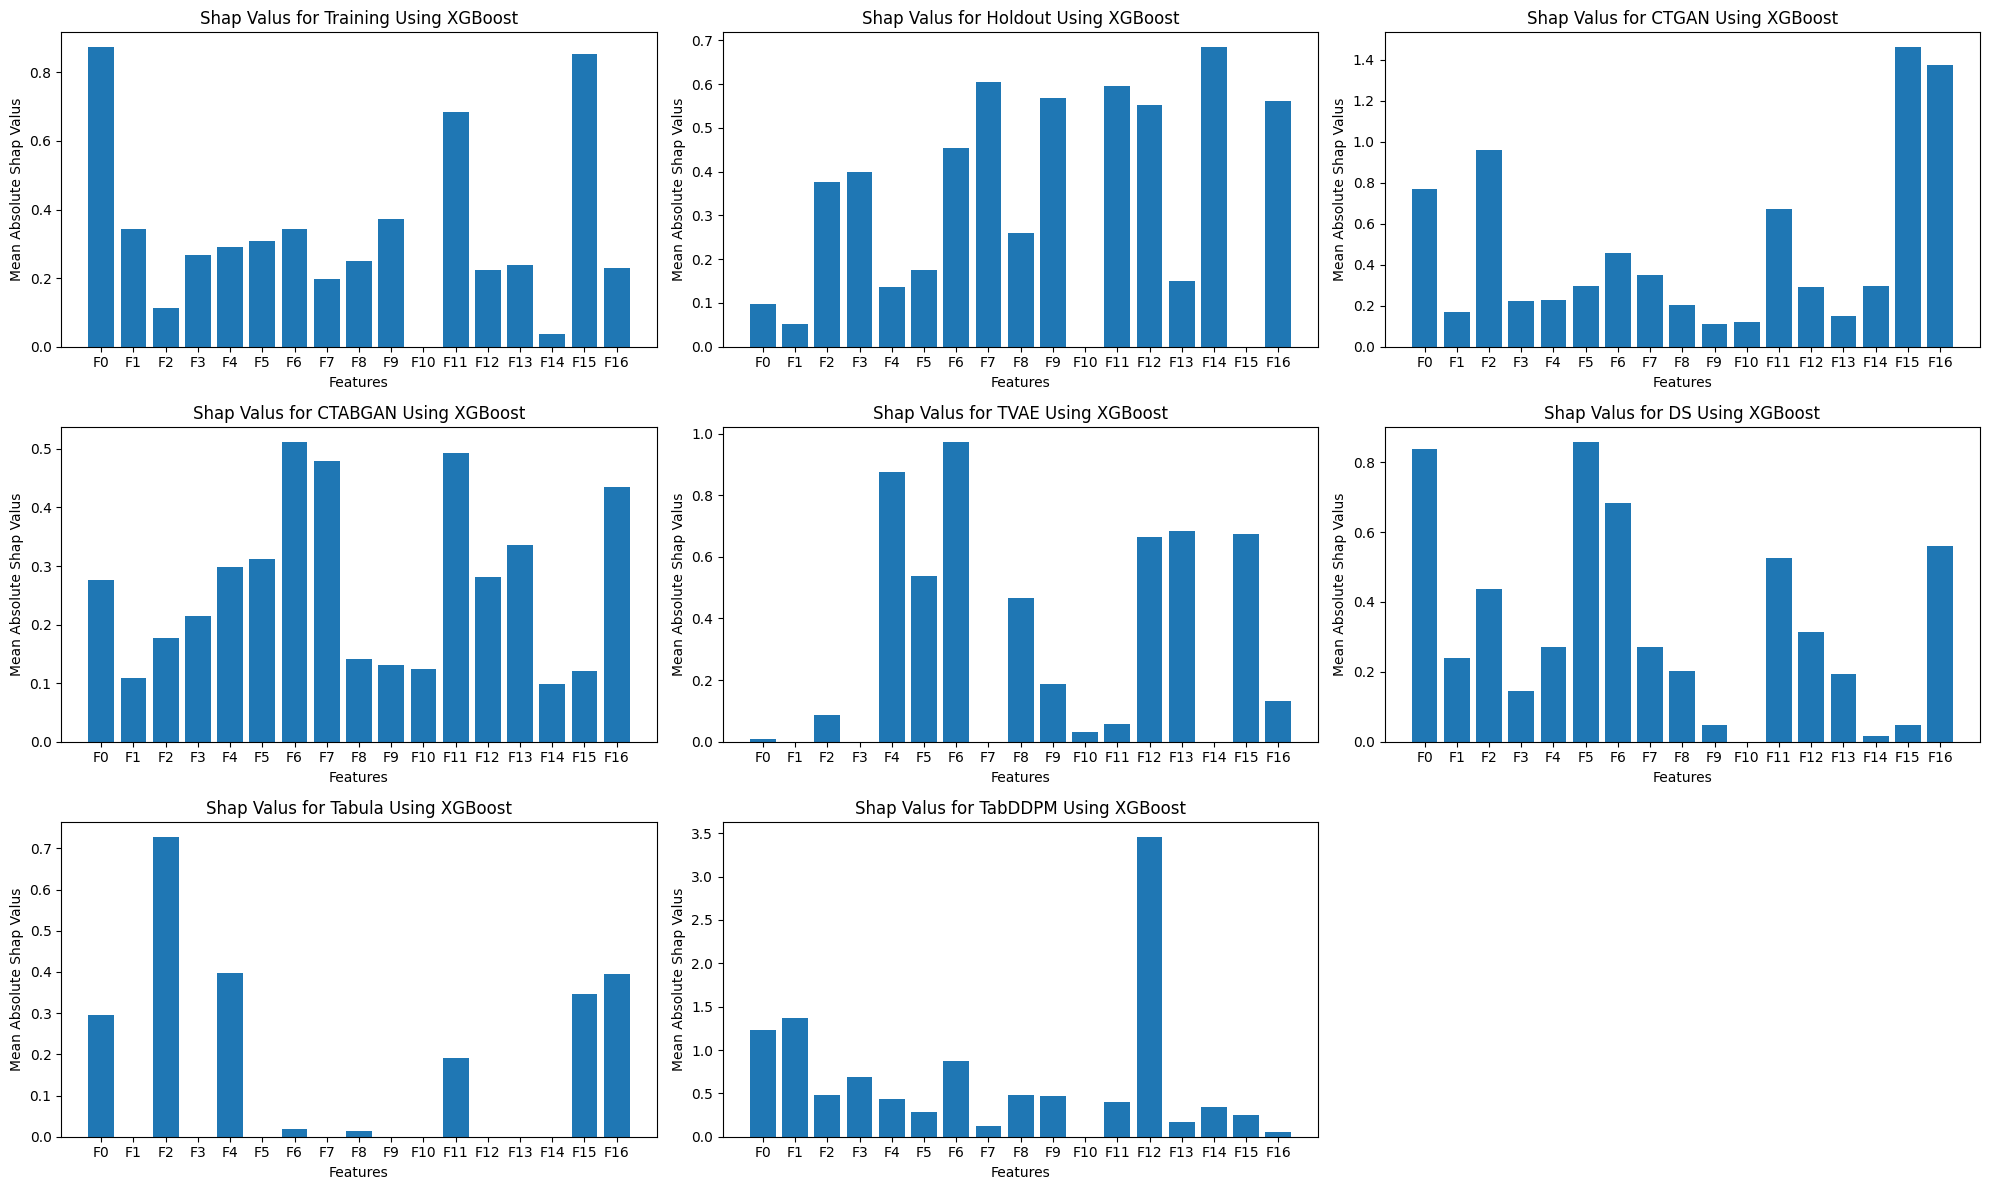

In [17]:
import numpy as np
import shap

fig, ax = plt.subplots(3, 3, figsize=(20, 12))
ax = ax.flatten()
for i, sample in enumerate(samples.keys()):
    importances = globals()[f'shap_imp_{sample}_rf']
    importances = np.mean(abs(importances.values), axis = 0)
    #shap.plots.bar(importances, show=False)
    ax[i].bar(features, importances)
    ax[i].set_title(f"Shap Valus for {sample} Using Random Forest")
    ax[i].set_xlabel("Features")
    ax[i].set_ylabel("Mean Absolute Shap Valus")
    
for j in range(len(samples.keys()), len(ax)):
    fig.delaxes(ax[j])
        
plt.tight_layout()
plt.show()
plt.close()


fig, ax = plt.subplots(3, 3, figsize=(20, 12))
ax = ax.flatten()
for i, sample in enumerate(samples.keys()):
    importances = globals()[f'shap_imp_{sample}_xgb']
    importances = np.mean(abs(importances.values), axis = 0)
    #shap.plots.bar(importances, show=False)
    ax[i].bar(features, importances)
    ax[i].set_title(f"Shap Valus for {sample} Using XGBoost")
    ax[i].set_xlabel("Features")
    ax[i].set_ylabel("Mean Absolute Shap Valus")
    
for j in range(len(samples.keys()), len(ax)):
    fig.delaxes(ax[j])
        
plt.tight_layout()
plt.show()
plt.close()